# Example of a reader for xarray given the variables Chris H processed



In [1]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
#%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr

%matplotlib widget
# Use seasborn for nicer looking inline plots if available 
#import seaborn as sns
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

#### chose a file to read



In [9]:
#download data from s3
#!aws s3 sync s3://pangeo-data-upload-oregon/floez/ATL10 ./Data
#!aws s3 sync s3://pangeo-data-upload-oregon/icesat2/Floes_are_Swell/ATL10-01_20181202120647_09910101_001_01.h5 ./Data

In [10]:
#use files locally
ATL10file='processed_ATL10-02_20181026024725_04200101_001_01.h5'
# ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'
localFilePath='/home/jovyan/Floes-are-Swell/Xi_Ross_Sea/Outputs/'+ATL10file


In [11]:
def MakeDataSet(filename, beam='gt1r'):
    ATL10 = h5py.File(localFilePath, 'r')

    # coordinates, start their lives as data arrays
    lons = xr.DataArray(ATL10[beam+'/freeboard_beam_segment/height_segments/longitude'][:],dims=['segs'])
    lons.name='lons'
    lats = xr.DataArray(ATL10[beam+'/freeboard_beam_segment/height_segments/latitude'][:],dims=['segs'])
    lats.name='lats'
    # add 360 to lons less than 0
    lons360 = lons.where(lons.values>0, other=lons.values+360)

    # this is the time hacked a bit since I am an idiot, it is within seconds
    delta_time=ATL10[beam+'/freeboard_beam_segment/height_segments/delta_time'][:] 
    time = np.datetime64('2018-01-01') + (delta_time-86400*0.015).astype('timedelta64[s]' ) 

    # variables in datasets, start their lives as data arrays too
    # give name to every variable you want to include in the data
    height = xr.DataArray(ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_height'][:],dims=['segs'])
    height.name = 'height'
    
    seg_length= xr.DataArray(ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_length_seg'][:],dims=['segs'])
    seg_length.name = 'seg_length'
    
    isita_lead = xr.DataArray(ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'][:],dims=['segs'])
    isita_lead.name = 'isita_lead'
    
    #add more about freeboard from ATL10 that does not exist in ATL07
    freeboard = xr.DataArray(ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'][:],dims=['segs']) 
    freeboard.name = 'freeboard'
    
    #add more about leads from ATL10 that does not exist in ATL07
    lead_length = xr.DataArray(ATL10[beam+'/leads/lead_length'][:],dims=['lead'])
    lead_length.name='lead_length'
    
    lead_lon = xr.DataArray(ATL10[beam+'/leads/longitude'][:],dims=['lead'])
    lead_lon.name='lead_lon'
    
    lead_lat = xr.DataArray(ATL10[beam+'/leads/latitude'][:],dims=['lead'])
    lead_lat.name='lead_lat'

  
        
    # merging all datarrays (they have to have names)
    ds=xr.merge([freeboard,seg_length,height,isita_lead,lead_length,lead_lon,lead_lat])
    
    # now we add more dataarrays 
    #ds['mss'] = mss
    #ds['seg_length'] = seg_length
    #ds['quality_flag'] = quality_flag
    #ds['isita_lead'] = isita_lead

    
    ds.coords['lon'] = lons
    ds.coords['lat'] = lats
    ds.coords['time'] = xr.DataArray(time,dims=['segs'])
    ds.coords['delta_time'] = xr.DataArray(delta_time,dims=['segs'])

    ds.coords['lon360'] = lons360
    ds.coords['segs'] = xr.DataArray(np.arange(0,len(height),1),dims=['segs'])
    

    print('\n\nTake a look at the dataset we made \n')
    print(ds)
    

    return ds


In [12]:
ds1r = MakeDataSet(localFilePath, beam = 'gt1r')
ds1l = MakeDataSet(localFilePath, beam = 'gt1l')



Take a look at the dataset we made 

<xarray.Dataset>
Dimensions:      (lead: 25, segs: 1823)
Coordinates:
    lon          (segs) float64 173.7 173.7 173.7 173.7 ... 172.1 172.1 172.1
    lat          (segs) float64 -77.35 -77.35 -77.35 ... -75.02 -75.02 -75.02
    time         (segs) datetime64[ns] 2018-10-26T03:39:48 ... 2018-10-26T03:40:25
    delta_time   (segs) float64 2.576e+07 2.576e+07 ... 2.576e+07 2.576e+07
    lon360       (segs) float64 173.7 173.7 173.7 173.7 ... 172.1 172.1 172.1
  * segs         (segs) int64 0 1 2 3 4 5 6 ... 1817 1818 1819 1820 1821 1822
Dimensions without coordinates: lead
Data variables:
    freeboard    (segs) float32 3.4028235e+38 3.4028235e+38 ... 0.3436271
    seg_length   (segs) float32 109.45984 69.17922 ... 66.78006 74.37235
    height       (segs) float32 -0.11231539 -0.12112356 ... 0.39258882
    isita_lead   (segs) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lead_length  (lead) float32 40.118298 28.200863 ... 129.88344 33

In [13]:
#%matplotlib inline
#plt.hist(ds1r.lead_length);
# %matplotlib widget
# plt.plot(ds1r.lat,ds1r.freeboard,'r-');
# plt.ylim(0,4);

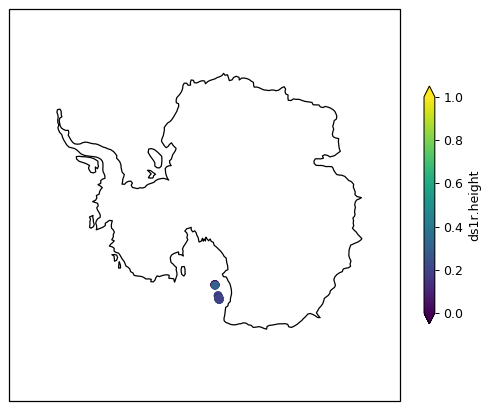

In [32]:
%matplotlib inline

var='ds1r.height'
#dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=70))
tmp=ds1r.height<1e6
elev=ds1r.height.where(tmp)
lat=ds1r.lat.where(tmp)
#plt.scatter(ds1r.lon,ds1r.lat,c=ds1r.height, cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(ds1r.lon[::20],ds1r.lat[::20],c=elev[::20], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, -60, -90], ccrs.PlateCarree())

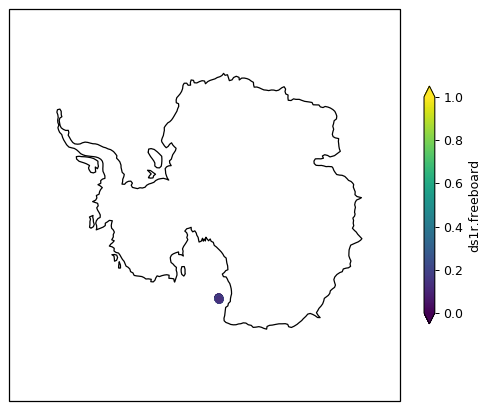

In [79]:
%matplotlib inline

var='ds1r.freeboard'
#dF07.along_track_distance
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=70))
tmp=ds1r.freeboard<10
fb=ds1r.freeboard.where(tmp)
lat=ds1r.lat.where(tmp)
#plt.scatter(ds1r.lon,ds1r.lat,c=ds1r.height, cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(ds1r.lon[::20],ds1r.lat[::20],c=fb[::20], cmap='viridis', vmin=0, vmax=1, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, -60, -90], ccrs.PlateCarree())

In [33]:
# # Select variable of interest from the dataframe columns
# # choices are 'height' or 'seg_dist' or other variables in the dataset
# %matplotlib widget
# cvar='freeboard'

# da = ds1r[cvar]
# plt.figure(figsize=(7,7), dpi= 90)
# # Make a new projection "NorthPolarStereo"
# ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=70))
# plt.scatter(ds1r.lon, ds1r.lat, c=da, cmap='viridis', transform=ccrs.PlateCarree())
# #plt.pcolormesh(lons, lats, tile_to_plot,
# #               transform=ccrs.PlateCarree());

# ax.coastlines()
# #ax.drawmeridians()
# plt.colorbar(label=cvar, shrink=0.5, extend='both')

# # Limit the map to -60 degrees latitude and below.
# ax.set_extent([-180, 180, -60, -90], ccrs.PlateCarree())

In [48]:
# %matplotlib widget
# #plt.plot(lat[:200],elev[:200]);
# plt.plot(lat,elev)


(0, 2)

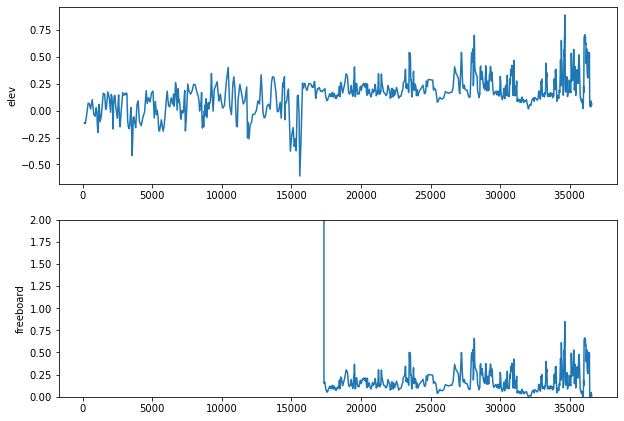

In [82]:
track_dist = np.cumsum(ds1r.seg_length)
ds1r['track_dist'] = track_dist

%matplotlib inline
end = 1000

plt.figure(figsize=(10, 15))
plt.subplot(411)

plt.plot(ds1r.track_dist[:end],ds1r.height[0:end]);
plt.ylabel('elev')

plt.subplot(412)
plt.plot(ds1r.track_dist[:end],ds1r.freeboard[0:end]);
plt.ylabel('freeboard')
plt.ylim(0,2)

Peak Wavenumber is 0.0013324543430423706 1/m
Peak Wavelength is 238.88990106557728 m


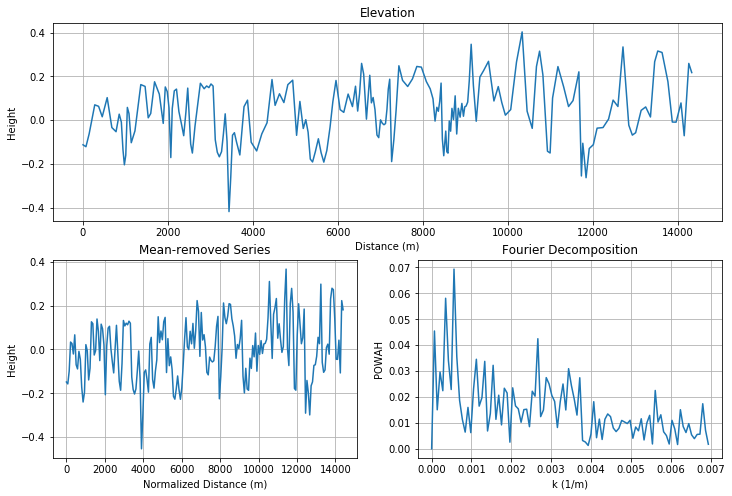

In [74]:
import scipy.fftpack

al=0;

le=200;


xshort = ds1r.track_dist[al:al+le]

xshort = xshort - xshort[0]

dx = np.diff(xshort)

dx = dx.mean()

latshort = ds1r.lat[al:al+le]

elevshort = elev[al:al+le]

#concshort = ds1r.conc[al:al+le]/100

f = plt.figure(figsize=(12,8))

ax0 = f.add_subplot(211)

ax1 = f.add_subplot(223)

ax2 = f.add_subplot(224)

N = len(xshort)

# sample spacing

xmod = np.linspace(0.0,N*dx,N)

y = elevshort - elevshort.mean()

yf = scipy.fftpack.fft(y)

xf = np.linspace(0.0, 1.0/(2.0*dx), N//2)

ax0.plot(xshort,elevshort)

#ax0.plot(xshort,xshort)

ax0.set_title('Elevation')

ax0.set_xlabel('Distance (m)')

ax0.set_ylabel('Height')

ax0.grid()

# axs[1].subplot(2,1,1)

ax1.plot(xmod,y)

ax1.set_title('Mean-removed Series')

ax1.set_xlabel('Normalized Distance (m)')

ax1.set_ylabel('Height')

ax1.grid()

# plt.subplot(2,1,2)

ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

# ax2.loglog(np.divide(1,xf), 2.0/N * np.abs(yf[0:N//2]))

ax2.grid()

ax2.set_title('Fourier Decomposition')

ax2.set_xlabel('k (1/m)')

ax2.set_ylabel('POWAH')

maxcal = np.argmax(yf[0:N//2])

max_f = xf[maxcal]

max_lam = 1/(np.pi*max_f)

print('Peak Wavenumber is ' + str(max_f) + ' 1/m')

print('Peak Wavelength is ' + str(max_lam) + ' m')
